# EMEPy Monitors

This notebook demonstrates how to use monitors in EMEPy to visualize field propagation. 

In [1]:
# from emepy.ann import ANN, MSNeuralNetwork
from emepy.fd import MSEMpy
from emepy.eme import Layer, EME
import numpy as np
from matplotlib import pyplot as plt

num_periods = 3  # Number of Periods for Bragg Grating
length = .159 # Length of each segment of BG, Period = Length * 2
wavelength = 1.55 # Wavelength
num_modes = 1  # Number of Modes
mesh = 128 # Number of mesh points
width1 = 0.46 # Width of first core block
width2 = 0.54 # Width of second core block 
thickness = 0.22 # Thicnkess of the core
modesolver = MSEMpy # Which modesolver to use

eme = EME(num_periods=num_periods)

mode_solver1 = modesolver(
    wavelength,
    width1,
    thickness,
)  # First half of bragg grating

mode_solver2 = modesolver(
    wavelength,
    width2,
    thickness,
)  # Second half of bragg grating

eme.add_layer(Layer(mode_solver1, num_modes, wavelength, length))  # First half of bragg grating
eme.add_layer(Layer(mode_solver2, num_modes, wavelength, length))  # Second half of bragg grating

current state: start


## 2D Monitors

#### XZ Plane

The most useful monitor type shows the width cross section along the propagation direction ('xz'). This can be used to verify geometries and visualize field propagation. The available components so far available to users are as follows:

- Ex: complex Electric field in the x (width) direction
- Ey: complex Electric field in the y (thickness) direction
- Ez: complex Electric field in the z (propagation/length) direction
- Hx: complex Magnetic field in the x (width) direction
- Hy: complex Magnetic field in the y (thickness) direction
- Hz: complex Magnetic field in the z (propagation/length) direction
- n: refractive index (units are actually of permittivity)
- E: $|Electric$ $Field|^2$
- H: $|Magnetic$ $Field|^2$

current state: start
No sources defined, defaulting to left_coeffs=[1]
current state: mode_solving


2it [00:09,  4.70s/it]


current state: finished_modes
current state: layer_propagating


1it [00:00, 37.31it/s]


current state: finished_layer
current state: network_building
current state: finished_network
current state: field_propagating


6it [00:00, 36.66it/s]


current state: finished


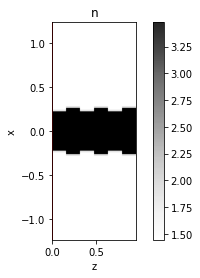

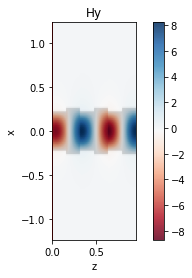

In [2]:
eme.reset(full_reset=False)

monitor = eme.add_monitor(axes="xz")

eme.propagate()  # propagate at given wavelength

plt.figure()
monitor.visualize(component="n")
plt.colorbar()
plt.show()

plt.figure()
monitor.visualize(component="Hy")
plt.colorbar()
plt.show()

#### YZ Plane

You can look in the thickness plane ('yz') which is often times invariant along the length depending on the foundry process. 

current state: start
No sources defined, defaulting to left_coeffs=[1]
current state: mode_solving


2it [00:09,  4.53s/it]


current state: finished_modes
current state: layer_propagating


1it [00:00, 52.38it/s]


current state: finished_layer
current state: network_building
current state: finished_network
current state: field_propagating


6it [00:00, 29.95it/s]


current state: finished


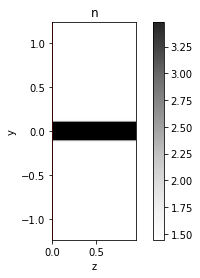

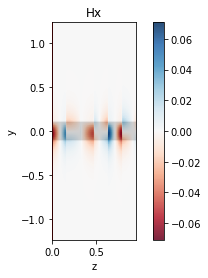

In [3]:
eme.reset(full_reset=False)

monitor = eme.add_monitor(axes="yz")

eme.propagate()  # propagate at given wavelength

plt.figure()
monitor.visualize(component="n")
plt.colorbar()
plt.show()

plt.figure()
monitor.visualize(component="Hx")
plt.colorbar()
plt.show()

#### XY Plane

You can create multiple monitors, and monitors which record cross sectional ('xy') data. 

current state: start
No sources defined, defaulting to left_coeffs=[1]
current state: mode_solving


2it [00:09,  4.58s/it]


current state: finished_modes
current state: layer_propagating


1it [00:00, 54.62it/s]


current state: finished_layer
current state: network_building
current state: finished_network
current state: field_propagating


6it [00:00, 35.13it/s]

current state: finished


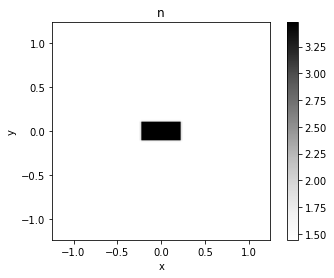

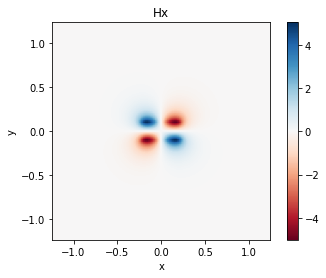

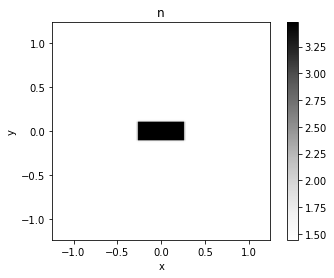

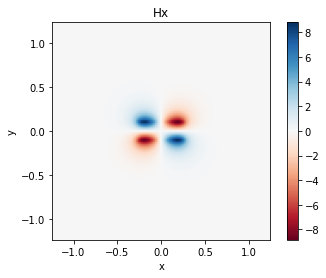

In [4]:
eme.reset(full_reset=False)

monitor_small = eme.add_monitor(axes="xy", location=0)
monitor_large = eme.add_monitor(axes="xy", location=0.2)

eme.propagate()  # propagate at given wavelength

plt.figure()
monitor_small.visualize(component="n")
plt.colorbar()
plt.show()

plt.figure()
monitor_small.visualize(component="Hx")
plt.colorbar()
plt.show()

plt.figure()
monitor_large.visualize(component="n")
plt.colorbar()
plt.show()

plt.figure()
monitor_large.visualize(component="Hx")
plt.colorbar()
plt.show()

#### Get Array

Users do not have to use the visualize() method to work with field data. The get_array() method allows users to work with the arrays of data themselves. The arguments are the same as for visualize() and it returns a list of each axis grid i.e. (x,z) and the field data. 

current state: start
No sources defined, defaulting to left_coeffs=[1]
current state: mode_solving


2it [00:15,  7.58s/it]


current state: finished_modes
current state: layer_propagating


1it [00:00, 40.94it/s]


current state: finished_layer
current state: network_building
current state: finished_network
current state: field_propagating


6it [00:00, 21.16it/s]


current state: finished


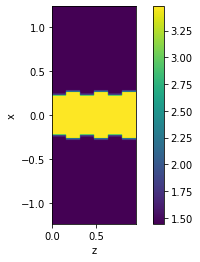

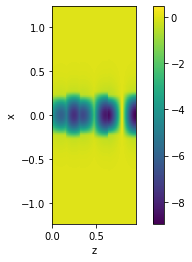

In [5]:
eme.reset(full_reset=False)

monitor = eme.add_monitor(axes="xz")

eme.propagate()  # propagate at given wavelength
x, z, index = monitor.get_array(component="n", axes="xz")
x, z, field = monitor.get_array(component="Hy", axes="xz")

plt.figure()
plt.imshow(np.real(index), extent=[z[0], z[-1], x[0], x[-1]])
plt.xlabel('z')
plt.ylabel('x')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.real(field), extent=[z[0], z[-1], x[0], x[-1]])
plt.xlabel('z')
plt.ylabel('x')
plt.colorbar()
plt.show()

#### Custom Z Range

Users can specify where in z they care to visualize fields. By specifying in add_monitor() before propagation, users can limit how much field data is stored and thus how much memory is consumed. By specifying after propagation in visualize(), users can visualize a subset of the data that is stored. 

current state: start
No sources defined, defaulting to left_coeffs=[1]
current state: mode_solving


2it [00:13,  6.56s/it]


current state: finished_modes
current state: layer_propagating


1it [00:00, 68.61it/s]


current state: finished_layer
current state: network_building
current state: finished_network
current state: field_propagating


6it [00:00, 24.16it/s]


current state: finished


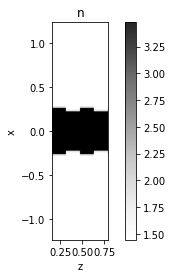

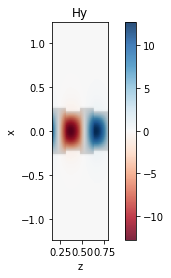

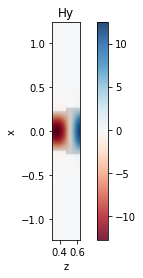

current state: start


In [6]:
eme.reset(full_reset=False)

monitor = eme.add_monitor(axes="xz", z_range=(1*0.159, 5*0.159))

eme.propagate()  # propagate at given wavelength

plt.figure()
monitor.visualize(component="n", axes="xz")
plt.colorbar()
plt.show()

plt.figure()
monitor.visualize(component="Hy", axes="xz")
plt.colorbar()
plt.show()

# Smaller subset of fields stored
plt.figure()
monitor.visualize(component="Hy", axes="xz", z_range=(2*0.159, 4*0.159))
plt.colorbar()
plt.show()

eme.reset()

#### Custom XY Mesh Grid

In some instances, it's optimal to be able to extract field data on a different grid than that used to perform the simulation. The most applicable example is when using EMEPy's neural networks. For simplicity, EMEPy's ANN  only solves on a 128x128 mesh grid for simplicity (not having to train multiple networks). Users can solve using the ANN and then interpolate onto a more custom mesh grid. 

In [7]:
import emepy
from emepy.eme import Layer, EME
from emepy.mode import Mode
from emepy.ann import MSNeuralNetwork, ANN
import numpy as np
from matplotlib import pyplot as plt

# Geometric parameters
width1 = 0.7  # Width of left waveguide
thickness1 = 0.22  # Thickness of left waveguide
width2 = 0.3  # Width of right waveguide
thickness2 = 0.22  # Thickness of right waveguide
wavelength = 1.55  # Wavelength of light (m)
length = 5  # Length of the waveguides
taper_length = 0.75  # The length of the taper
num_modes=1 #Number of modes
taper_density = 7 # Number of taper segments
wg_length = 0.5 * (length - taper_length)  # Length of each division in the taper

ann = ANN()
eme = EME()  # Choose either a normal eme or a periodic eme (PeriodicEME())

# first layer is a straight waveguide
mode1 = MSNeuralNetwork(
    ann, 
    wavelength,
    width1,
    thickness1
)
straight1 = Layer(mode1, num_modes, wavelength, wg_length)
eme.add_layer(straight1)

# create the discrete taper with a fine enough taper density to approximate a continuous linear taper
widths = np.linspace(width1, width2, taper_density)
thicknesses = np.linspace(thickness1, thickness2, taper_density)
taper_length_per = taper_length / taper_density if taper_density else None

# add the taper layers
for i in range(taper_density):
    solver = MSNeuralNetwork(ann, wavelength, widths[i], thicknesses[i])
    taper_layer = Layer(solver, num_modes, wavelength, taper_length_per)
    eme.add_layer(taper_layer)

# last layer is a straight waveguide of smaller geometry
mode2 = MSNeuralNetwork(ann, wavelength, width2, thickness2)
straight2 = Layer(mode2, num_modes, wavelength, wg_length)
eme.add_layer(straight2)

monitor = eme.add_monitor(axes="xz")

eme.propagate(left_coeffs=np.array([1]))  # Run the eme

x_grid = np.linspace(0,2.5,100)
x, z, n = monitor.get_array(axes="xz", component="n", grid_x=x_grid)
plt.figure()
plt.imshow(np.real(n))
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ianhammond/GitHub/emepy/emepy/models/Hx_chunks/'

## 3D Monitors

If a 3D monitor is chosen ("xyz") more field data is stored requiring more memory. However, this lets users visualize any cross section in the entire simulation (or specified) domain or extract the entire 3D field as an array. 

In [ ]:
import emepy
from emepy import Layer, EME, Mode, MSEMpy
import numpy as np
from matplotlib import pyplot as plt
from emepy.tools import Si, SiO2

# Geometric parameters
wavelength = 1.55 # Wavelength
width = 0.4  # Width of left waveguide
gap = 0.2 # Gap between waveguides
thickness = 0.22  # Thickness of left waveguide
num_modes=2 # Number of modes
mesh=100 # Number of mesh points
core_index=Si(wavelength*1e6) # Silicon core
cladding_index=SiO2(wavelength*1e6) # Oxide cladding
x = np.linspace(-2,2,mesh)
n = np.ones(mesh) * cladding_index

# Create simulation 
eme_2 = EME()

# Create left waveguide
single_left_edge = -gap/2-width
single_right_edge = -gap/2
single_n = np.where((single_left_edge <= x) * (x <= single_right_edge), core_index, n)

single_channel = MSEMpy(
    wavelength,
    width=None,
    thickness=thickness,
    cladding_index=cladding_index,
    num_modes=num_modes,
    mesh=mesh,
    x=x,
    y=x,
    n=single_n
)

# Create left waveguide
left_edge = -gap/2-width
right_edge = -gap/2
n = np.where((left_edge <= x) * (x <= right_edge), core_index, n)

# Create right waveguide
left_edge = gap/2
right_edge = gap/2+width
n = np.where((left_edge <= x) * (x <= right_edge), core_index, n)

two_channel = MSEMpy(
    wavelength,
    width=None,
    thickness=thickness,
    cladding_index=cladding_index,
    num_modes=num_modes,
    mesh=mesh,
    x=x,
    y=x,
    n=n
)

eme_2.add_layer(Layer(single_channel, num_modes, wavelength, 0.5))  # First half of bragg grating
eme_2.add_layer(Layer(two_channel, num_modes, wavelength, 25))  # Second half of bragg grating

monitor = eme_2.add_monitor(axes="xyz")

eme_2.propagate()  # propagate at given wavelength

### Visualize 2D subset

In [ ]:
plt.figure()
monitor.visualize(component="n", axes="xz")
plt.colorbar()
plt.show()

plt.figure()
monitor.visualize(component="Hy", axes="xz")
plt.colorbar()
plt.show()

### Extract full 3D field

In [ ]:
x, y, z, field = monitor.get_array(component="E")

print("x shape: {}".format(x.shape))
print("y shape: {}".format(y.shape))
print("z shape: {}".format(z.shape))
print("field shape: {}".format(field.shape))